In [1]:
import json
import time
import random
import pymongo
import copy
import MyCommon
from pymongo import MongoClient
from collections import deque
import cassiopeia
from cassiopeia import riotapi
import numpy as np
from sklearn import preprocessing, cluster, decomposition
from scipy.cluster.vq import kmeans,vq
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.decomposition import FastICA, PCA
from sklearn import metrics
import matplotlib.pyplot as plt
from sets import Set

riotapi.set_region("KR")
riotapi.set_api_key("79428a9e-5d98-469b-9b9b-429c1a750d24")
riotapi.set_rate_limits((10, 10), (500, 600))
riotapi.print_calls(False)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:19: DeprecationWarning: the sets module is deprecated


In [2]:
client = MongoClient()
loladb = client.loladb73
matches_collection = loladb.matches
print matches_collection.count()

19695


In [3]:
champions = riotapi.get_champions()
dict_id2idx = dict()
dict_idx2id = dict()
dict_id2key = dict()
for a_idx, a_champion in enumerate(champions):
    champ_id = a_champion.id
    champ_key = a_champion.key
    dict_id2idx[champ_id] = a_idx
    dict_idx2id[a_idx] = champ_id
    dict_id2key[champ_id] = champ_key
    
#print dict_id2key[dict_idx2id[132]]
#print dict_id2key

def GetIdxFromId(a_id):
    return dict_id2idx[a_id]

def GetIdFromIdx(a_idx):
    return dict_idx2id[a_idx]

def GetNameFromId(a_id):
    return dict_id2key[a_id]

print dict_id2key

{1: u'Annie', 2: u'Olaf', 3: u'Galio', 4: u'TwistedFate', 5: u'XinZhao', 6: u'Urgot', 7: u'Leblanc', 8: u'Vladimir', 9: u'FiddleSticks', 10: u'Kayle', 11: u'MasterYi', 12: u'Alistar', 13: u'Ryze', 14: u'Sion', 15: u'Sivir', 16: u'Soraka', 17: u'Teemo', 18: u'Tristana', 19: u'Warwick', 20: u'Nunu', 21: u'MissFortune', 22: u'Ashe', 23: u'Tryndamere', 24: u'Jax', 25: u'Morgana', 26: u'Zilean', 27: u'Singed', 28: u'Evelynn', 29: u'Twitch', 30: u'Karthus', 31: u'Chogath', 32: u'Amumu', 33: u'Rammus', 34: u'Anivia', 35: u'Shaco', 36: u'DrMundo', 37: u'Sona', 38: u'Kassadin', 39: u'Irelia', 40: u'Janna', 41: u'Gangplank', 42: u'Corki', 43: u'Karma', 44: u'Taric', 45: u'Veigar', 48: u'Trundle', 50: u'Swain', 51: u'Caitlyn', 53: u'Blitzcrank', 54: u'Malphite', 55: u'Katarina', 56: u'Nocturne', 57: u'Maokai', 58: u'Renekton', 59: u'JarvanIV', 60: u'Elise', 61: u'Orianna', 62: u'MonkeyKing', 63: u'Brand', 64: u'LeeSin', 67: u'Vayne', 68: u'Rumble', 69: u'Cassiopeia', 72: u'Skarner', 74: u'Heimerd

In [4]:
X = []
Y = []
for a_idx, a_match in enumerate(matches_collection.find()):
    #check the champs appear in this game
    if a_match['matchDuration'] <= 1200:
        continue
        
    winning_side = -1
    if a_match['teams'][0]['winner'] == True and a_match['teams'][1]['winner'] == False:
        winning_side = 0
    if a_match['teams'][0]['winner'] == False and a_match['teams'][1]['winner'] == True:
        winning_side = 1 
    if winning_side == -1:
        continue
        
    participants = a_match['participants']
    champions = []
    for a_participant in participants:
        champions.append(GetNameFromId(a_participant['championId']))
    #print champions
    
    frame15 = a_match['timeline']['frames'][15]
    participantFrames = frame15['participantFrames']
    gold_blue = 0
    gold_red = 0
    for par_idx in range(10):
        if par_idx < 5:
            gold_blue += participantFrames[str(par_idx + 1)]['totalGold']
        else:
            gold_red += participantFrames[str(par_idx + 1)]['totalGold']
    #print gold_blue
    #print gold_red
    gold_delta_blue = gold_blue - gold_red
    gold_delta_red = gold_red - gold_blue
    result_blue = 0
    result_red = 0
    if winning_side == 0:
        result_blue = 1
    else:
        result_red = 1
        
    X.append(gold_delta_blue)
    X.append(gold_delta_red)
    Y.append(result_blue)
    Y.append(result_red)
        
    if a_idx % 1000 == 0:
        print a_idx

0
1000
3000
4000
6000


KeyboardInterrupt: 

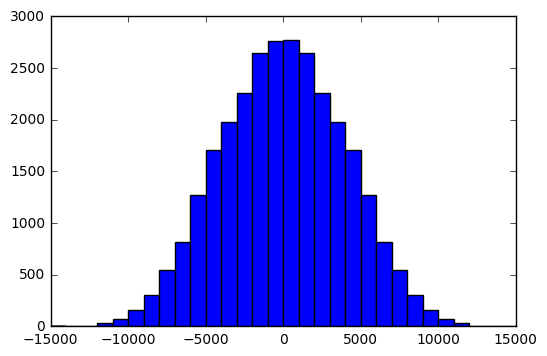

In [29]:
hist_bins = range(-15000, 16000, 1000)
(n, bins, patches) = plt.hist(X, bins = hist_bins)
plt.show()

In [30]:
print hist_bins
print bins
print n

[-15000, -14000, -13000, -12000, -11000, -10000, -9000, -8000, -7000, -6000, -5000, -4000, -3000, -2000, -1000, 0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000]
[-15000 -14000 -13000 -12000 -11000 -10000  -9000  -8000  -7000  -6000
  -5000  -4000  -3000  -2000  -1000      0   1000   2000   3000   4000
   5000   6000   7000   8000   9000  10000  11000  12000  13000  14000
  15000]
[  1.00000000e+00   3.00000000e+00   9.00000000e+00   3.20000000e+01
   7.20000000e+01   1.56000000e+02   3.09000000e+02   5.45000000e+02
   8.20000000e+02   1.26900000e+03   1.70400000e+03   1.98000000e+03
   2.26000000e+03   2.65100000e+03   2.76100000e+03   2.77000000e+03
   2.65000000e+03   2.25800000e+03   1.98200000e+03   1.70500000e+03
   1.27000000e+03   8.20000000e+02   5.45000000e+02   3.09000000e+02
   1.56000000e+02   7.20000000e+01   3.20000000e+01   9.00000000e+00
   3.00000000e+00   1.00000000e+00]


In [38]:
wins = np.zeros(30)
nums = np.zeros(30)
winrates = np.zeros(30)
for x_idx, x in enumerate(X):
    idx = (x + 15000) / 1000
    if Y[x_idx] == 1:
        wins[idx] += 1
    nums[idx] += 1
    
for i in range(30):
    winrates[i] = wins[i] / float(nums[i])

In [39]:
print winrates

[ 0.          0.          0.          0.          0.          0.00641026
  0.01618123  0.0146789   0.03780488  0.06304177  0.11795775  0.16161616
  0.2380531   0.32176537  0.44766389  0.55198556  0.67886792  0.76173605
  0.83753784  0.88211144  0.93700787  0.96219512  0.9853211   0.98381877
  0.99358974  1.          1.          1.          1.          1.        ]


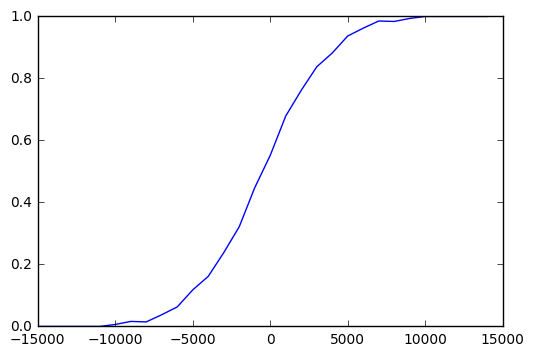

In [45]:
bins_x = range(-15000, 15000, 1000)
plt.plot(bins_x, winrates)
plt.show()

In [46]:
for a_idx, x in enumerate(bins_x):
    print (x + 500, winrates[a_idx])

(-14500, 0.0)
(-13500, 0.0)
(-12500, 0.0)
(-11500, 0.0)
(-10500, 0.0)
(-9500, 0.00641025641025641)
(-8500, 0.016181229773462782)
(-7500, 0.014678899082568808)
(-6500, 0.037804878048780487)
(-5500, 0.063041765169424738)
(-4500, 0.11795774647887323)
(-3500, 0.16161616161616163)
(-2500, 0.23805309734513275)
(-1500, 0.32176537155790269)
(-500, 0.44766388989496558)
(500, 0.55198555956678697)
(1500, 0.67886792452830191)
(2500, 0.76173604960141716)
(3500, 0.83753784056508573)
(4500, 0.8821114369501466)
(5500, 0.93700787401574803)
(6500, 0.96219512195121948)
(7500, 0.98532110091743119)
(8500, 0.98381877022653719)
(9500, 0.99358974358974361)
(10500, 1.0)
(11500, 1.0)
(12500, 1.0)
(13500, 1.0)
(14500, 1.0)


In [4]:
def AddToDict(a_dict, a_key, a_value):
    if a_key in a_dict.keys():
        a_dict[a_key] += a_value
    else:
        a_dict[a_key] = a_value

In [5]:
#分析每个英雄/每类英雄的carry能力
role_X = {}
role_Y = {}
role_X['BOTTOM_DUO_SUPPORT'] = []
role_X['BOTTOM_DUO_CARRY'] = []
role_X['TOP_SOLO'] = []
role_X['JUNGLE_NONE'] = []
role_X['MIDDLE_SOLO'] = []
role_Y['BOTTOM_DUO_SUPPORT'] = []
role_Y['BOTTOM_DUO_CARRY'] = []
role_Y['TOP_SOLO'] = []
role_Y['JUNGLE_NONE'] = []
role_Y['MIDDLE_SOLO'] = []

champions_X = {}
champions_Y = {}
champions_morecs = {}

for a_id in dict_id2key:
    a_key = dict_id2key[a_id]
    champions_X[a_key] = []
    champions_Y[a_key] = []


NEEDED_ROLES = ['BOTTOM_DUO_SUPPORT', 'BOTTOM_DUO_CARRY', 'TOP_SOLO', 'JUNGLE_NONE', 'MIDDLE_SOLO']

for a_idx, a_match in enumerate(matches_collection.find()):
    #check the champs appear in this game
    if a_match['matchDuration'] <= 1200:
        continue
        
    winning_side = -1
    if a_match['teams'][0]['winner'] == True and a_match['teams'][1]['winner'] == False:
        winning_side = 0
    if a_match['teams'][0]['winner'] == False and a_match['teams'][1]['winner'] == True:
        winning_side = 1 
    if winning_side == -1:
        continue
        
    #only consider the match with standard laning
    #lane role
    #BOTTOM - DUO_SUPPORT
    #BOTTOM - DUO_CARRY
    #TOP - SOLO
    #JUNGLE - NONE
    #MIDDLE - SOLO
    participants = a_match['participants']
    lane_dict = {}
    for a_participant in participants:
        lane = a_participant['timeline']['lane']
        role = a_participant['timeline']['role']
        AddToDict(lane_dict, lane + '_' + role, 1)
        
    #print lane_dict
    if len(lane_dict) != 5:
        continue
        
    if 'BOTTOM_DUO_SUPPORT' not in lane_dict.keys():
        continue
        
    if 'BOTTOM_DUO_CARRY' not in lane_dict.keys():
        continue
        
    if 'TOP_SOLO' not in lane_dict.keys():
        continue
        
    if 'JUNGLE_NONE' not in lane_dict.keys():
        continue

    if 'MIDDLE_SOLO' not in lane_dict.keys():
        continue
        
    if lane_dict['BOTTOM_DUO_SUPPORT'] == 2 and lane_dict['BOTTOM_DUO_CARRY'] == 2 and lane_dict['TOP_SOLO'] == 2 and lane_dict['JUNGLE_NONE'] == 2 and lane_dict['MIDDLE_SOLO'] == 2:
        #print 'Standard laning'
        abc = 1
    else:
        continue
    
    champions = []
    for a_participant in participants:
        champions.append(GetNameFromId(a_participant['championId']))
    
    frame10 = a_match['timeline']['frames'][10]
    participantFrames = frame10['participantFrames']
    
    blue_golds = {}
    red_golds = {}
    blue_champions = {}
    red_champions = {}
    
    for par_idx, a_participant in enumerate(participants):
        lane = a_participant['timeline']['lane']
        role = a_participant['timeline']['role']
        full_role = lane + '_' + role
        
        current_gold = participantFrames[str(par_idx + 1)]['totalGold']
        if par_idx < 5:
            #blue side
            blue_golds[full_role] = current_gold
            blue_champions[full_role] = GetNameFromId(a_participant['championId'])
        else:
            #red side
            red_golds[full_role] = current_gold
            red_champions[full_role] = GetNameFromId(a_participant['championId'])
            
    #print blue_golds
    #print red_golds
    for a_key in blue_golds:
        #iterate each position
        delta_gold = blue_golds[a_key] - red_golds[a_key]
        #print delta_gold
        role_X[a_key].append(delta_gold)
        blue_champ = blue_champions[a_key]
        red_champ = red_champions[a_key]
        champions_X[blue_champ].append(delta_gold)
        champions_X[red_champ].append(delta_gold * -1)
        if winning_side == 0:
            role_Y[a_key].append(1)
            champions_Y[blue_champ].append(1)
            champions_Y[red_champ].append(0)
        else:
            role_Y[a_key].append(0)
            champions_Y[blue_champ].append(0)
            champions_Y[red_champ].append(1)
            
    if a_idx % 500 == 0:
        print a_idx

0
500
1500
2500
3000
3500
4000
4500
5500
6000
6500
7000
7500
8000
9000
9500
10000
10500
11000
11500
12000
13000
13500
14000
15000
15500
16000
17500
18000
18500
19000
19500


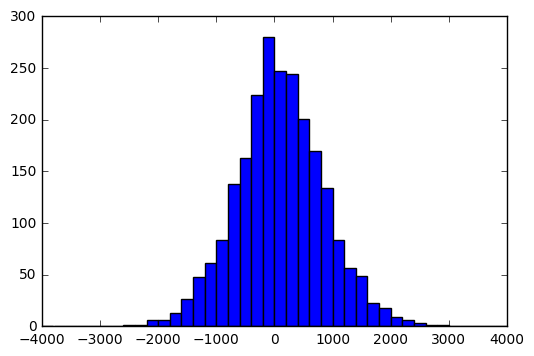

In [9]:
hist_bins = range(-4000, 4200, 200)
(n, bins, patches) = plt.hist(champions_X['Caitlyn'], bins = hist_bins)
plt.show()

In [11]:
print max(role_X['MIDDLE_SOLO'])
print min(role_X['MIDDLE_SOLO'])

2752
-3210


In [10]:
from sklearn import linear_model

In [116]:
for a_key in NEEDED_ROLES:
    print (a_key)
    wins = np.zeros(40)
    nums = np.zeros(40)
    winrates = np.zeros(40)
    for x_idx, x in enumerate(role_X[a_key]):
        idx = (x + 4000) / 200
        if role_Y[a_key][x_idx] == 1:
            wins[idx] += 1
        nums[idx] += 1

    for i in range(40):
        winrates[i] = wins[i] / float(nums[i])

    bins_x = range(-39, 41, 2)
    plt.plot(bins_x, winrates)
    
    
    #print len(bins_x)
    #print (nums)
    #print (winrates)
    X = []
    Y = []
    
    for a_idx in [-9, -7, -5, -3, -1, 1, 3, 5, 7, 9]:
        x_idx = (a_idx + 39)/2
        Y.append(winrates[x_idx])
        X.append([bins_x[x_idx], 1])
    
    #print X
    #print Y
    
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X, Y)
    print('Coefficients: \n')
    print (regr.coef_)
    print (regr.intercept_)
    #print('Prediction on 400: ', regr.predict([5, 1]))
    
    plt.plot(X, regr.predict(X), color='blue',
         linewidth=3)
    
    #plt.show()

BOTTOM_DUO_SUPPORT
Coefficients: 

[ 0.0227885  0.       ]
0.503190076098
BOTTOM_DUO_CARRY
Coefficients: 

[ 0.01771608  0.        ]
0.507181666613
TOP_SOLO
Coefficients: 

[ 0.01756804  0.        ]
0.508786288696
JUNGLE_NONE
Coefficients: 

[ 0.02320175  0.        ]
0.501357884209
MIDDLE_SOLO
Coefficients: 

[ 0.02175014  0.        ]
0.51301727886


In [40]:
regr = linear_model.LinearRegression()

A = [[1, 1], [2, 1], [3, 1], [4, 1], [5, 1]]
B = [3, 4, 5, 6, 7]

regr.fit(A, B)
print regr.coef_
print regr.intercept_

[ 1.  0.]
2.0


TahmKench
693
[ 0.03129208  0.        ]
0.521177432834
average gold lead/winrate:
-3.77200577201
[ 0.51999709]
0.500721500722


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


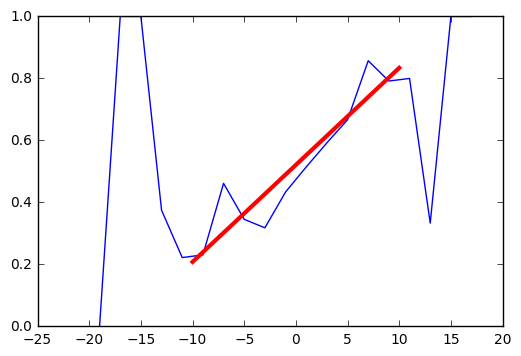

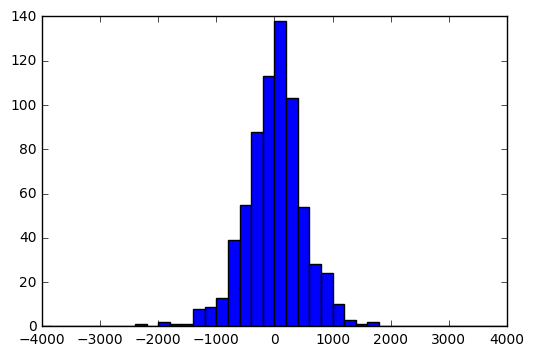

In [126]:
import csv
with open("whoscarry.csv", 'wb') as csvfile:
    csvfile.write(u'\ufeff'.encode('utf8'))
    csvwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    csvwriter.writerow(["Name", "Carry", "BaseWinrate", "AverageGoldDelta", "AverageWinrate", "GameCount"])
    
    A_list = {}
    B_list = {}
    for a_idx, a_id in enumerate(dict_id2key):
        #if a_idx != 10:
            #continue
        a_key = dict_id2key[a_id]
        #if a_key != target_key:
            #continue
            
        if a_key != "TahmKench":
            continue

        print(a_key) 
        wins = np.zeros(40)
        nums = np.zeros(40)
        winrates = np.zeros(40)
        #print champions_X[a_key]
        #print champions_Y[a_key]
        print (len(champions_X[a_key]))

        if len(champions_X[a_key]) < 500:
            continue

        #print len(champions_Y[a_key])
        for x_idx, x in enumerate(champions_X[a_key]):
            idx = (x + 4000) / 200
            #print (x_idx, x)
            if champions_Y[a_key][x_idx] == 1:
                wins[idx] += 1
            nums[idx] += 1

        for i in range(40):
            winrates[i] = wins[i] / float(nums[i])

        bins_x = range(-39, 41, 2)
        plt.plot(bins_x, winrates)

        #print len(bins_x)
        #print nums
        #print winrates
        X = []
        Y = []

        for a_idx in [-9, -7, -5, -3, -1, 1, 3, 5, 7, 9]:
            x_idx = (a_idx + 39)/2
            Y.append(winrates[x_idx])
            X.append([bins_x[x_idx], 1])

        #print X
        #print Y

        probit_X = []
        probit_Y = []

        for x_idx, x in enumerate(champions_X[a_key]):
            probit_X.append((x + 3500) / 7000.0)
            probit_Y.append(champions_Y[a_key][x_idx])

        regr = linear_model.LinearRegression()

        # Train the model using the training sets
        regr.fit(X, Y)
        #print('Coefficients: \n')
        print (regr.coef_)
        print (regr.intercept_)
        A_list[a_key] = regr.coef_
        B_list[a_key] = regr.intercept_
        #print('Prediction on 400: ', regr.predict([5, 1]))

        print("average gold lead/winrate:")
        average_mean = np.mean(champions_X[a_key])
        average_winrate = regr.predict([average_mean/100, 1])
        print (average_mean)
        print (average_winrate)
        print (np.mean(champions_Y[a_key]))

        dummy_x = range(-10, 12, 2)
        plt.plot(dummy_x, regr.predict([[a_x, 1] for a_x in dummy_x]), color='red',
             linewidth=3)
        plt.show()

        hist_bins = range(-4000, 4200, 200)
        (n, bins, patches) = plt.hist(champions_X[a_key], bins = hist_bins)
        plt.show()
        
        #a_key
        carry_rate = regr.coef_[0]
        winrate_0 = regr.intercept_
        average_moregold = average_mean
        #average_winrate
        csvwriter.writerow([a_key, carry_rate, winrate_0, average_moregold, average_winrate[0], len(champions_X[a_key])])
        break

In [32]:
print (type(probit_X))
#print probit_Y

<type 'list'>


In [13]:
from __future__ import print_function
import numpy as np
import statsmodels.api as sm

In [49]:
np_X = np.array(probit_X)
np_Y = np.array(probit_Y)
probit_mod = sm.Probit(np_X, np_Y)
probit_res = probit_mod.fit()
probit_margeff = probit_res.get_margeff()
print('Parameters: ', probit_res.params)
print('Marginal effects: ')
print(probit_margeff.summary())
print(probit_res.summary())

Optimization terminated successfully.
         Current function value: 0.690736
         Iterations 5
Parameters:  [-0.66991679]
Marginal effects: 
       Probit Marginal Effects       
Dep. Variable:                      y
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            -0.2403      0.048     -5.049      0.000        -0.334    -0.147
                          Probit Regression Results                           
Dep. Variable:                      y   No. Observations:                 3426
Model:                         Probit   Df Residuals:                     3425
Method:                           MLE   Df Model:                            0
Date:                Fri, 17 Feb 2017   Pseudo R-squ.:                -0.07893
Time:                        12:24:09   Log-Likelihood:             

In [37]:
probit_res.predict([0])

array([ 0.5])

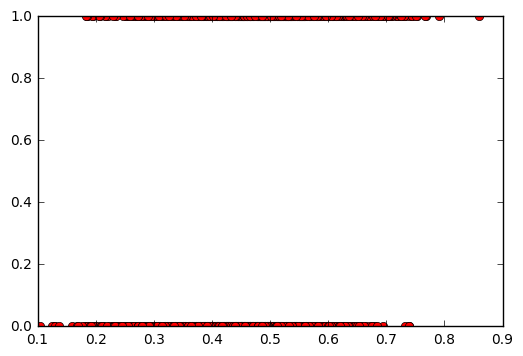

In [51]:
plt.plot(probit_X, probit_Y, 'ro')
plt.show()

In [71]:
A = [1, 2, 3]
B = [[a_b] for a_b in A]
print (A)
print (B)

[1, 2, 3]
[[1], [2], [3]]
